<a href="https://colab.research.google.com/github/nikVaviya/ML_code/blob/main/Cancer_Prediction_using_Gene_Expression_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for Cancer Prediction
The data used for this tutorial is an RNA-seq gene expression data for different cancer types. The rows represent cancer samples and the columns represent gene count values. The last column contains the cancer categories.

The original data can found here: https://archive.ics.uci.edu/ml/datasets/gene+expression+cancer+RNA-Seq#

## Required Libraries
 - numpy
 - matplotlib
 - seaborn
 - pandas
 - scikit

## Import Python libraries

In [3]:
#data handling
import pandas as pd
import numpy as np

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import MinMaxScaler

#feature selection
from sklearn.feature_selection import mutual_info_classif

#classification
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# performance metrics
from sklearn.metrics import balanced_accuracy_score,f1_score,precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score

## Read data

In [5]:

#read data directly from a github repository

file_url='https://github.com/vappiah/Machine-Learning-Tutorials/raw/main/datasets/cancer_gene_expression.zip'

dataframe=pd.read_csv(file_url)



## Data Exploration & Cleaning




In [6]:
#let's check the number of samples and features
#note:the last column contain the labels. it is not considered as a feature

print(dataframe.shape)

(801, 8001)


In [7]:
#let's check some of the columns (first, second and third columns)
print(dataframe.columns[0:3])

Index(['gene_1', 'gene_2', 'gene_3'], dtype='object')


In [8]:
#lets check the name of the last column of this dataframe

dataframe.columns[-1]

'Cancer_Type'

In [9]:
#check for missing values
datanul=dataframe.isnull().sum()
g=[i for i in datanul if i>0]

print('columns with missing values:%d'%len(g))

columns with missing values:0


**GOOD JOB!!!!.**

In [10]:
#let's check how many different cancer types are there in the data
#note: in this tutorial the cancer types will be referred to as classes or labels

print(dataframe['Cancer_Type'].value_counts())

Cancer_Type
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


We can see that there are 5 classes/cancer types. And you can also see the number of samples diagnosed with a cancer type
      

<Axes: xlabel='Cancer_Type'>

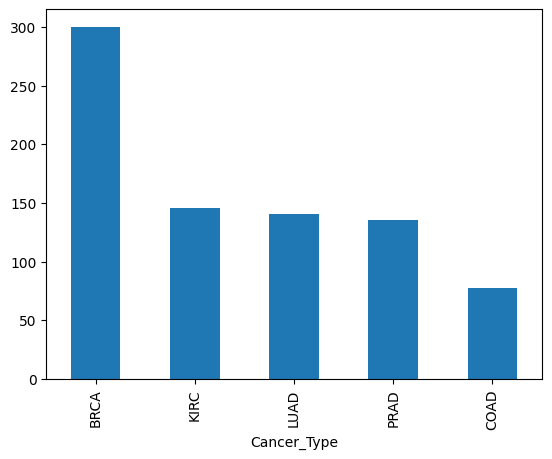

In [11]:
#plot a bar chat to display the class distribution

dataframe['Cancer_Type'].value_counts().plot.bar()


## **Data preprocesing**
This is done to put the data in an appropriate format before modelling


In [12]:
#we will now seperate the feature values from the class. we do this because scikit-learn requires that features and class are separated before parsing them to the classifiers.

X=dataframe.iloc[:,0:-1]
y=dataframe.iloc[:,-1]

In [13]:
X.shape

(801, 8000)

In [14]:
y.shape

(801,)

\
**Encode labels**

The labels for this data are categorical and we therefore have to convert them to numeric forms. This is referred to as encoding. Machine learning models usually require input data to be in numeric forms, hence we encoding the labels.

In [15]:
#let's encode target labels (y) with values between 0 and n_classes-1.
#encoding will be done using the LabelEncoder
label_encoder=LabelEncoder()
label_encoder.fit(y)
y_encoded=label_encoder.transform(y)
labels=label_encoder.classes_
classes=np.unique(y_encoded)

In [16]:
labels

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype=object)

In [17]:
classes

array([0, 1, 2, 3, 4])

\
**Data Splitting**\
We will now split the data into training and test subsets.
The training data is initially parsed to the machine learning model. this is to enable the model to identify discriminatory patterns which can be used to make future predictions.
The testing data is used to evaluate the model after the training phase.

In [18]:
#split data into training and test sets
X_train,X_test,y_train,y_test=train_test_split(X,y_encoded,test_size=0.2,random_state=42)

In [19]:
dataframe.iloc[:,0:10].describe()

,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10
count,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000,801.000000
mean,0.026642,0.231049,0.010844,2.405459,0.005799,0.065640,0.022036,0.028394,0.703998,1.916364
std,0.136850,0.656692,0.153859,0.797236,0.052265,0.213557,0.148917,0.161606,0.779321,0.877010
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.898595,0.000000,0.000000,0.000000,0.000000,0.000000,1.357214
50%,0.000000,0.000000,0.000000,2.358284,0.000000,0.000000,0.000000,0.000000,0.518031,1.877862
75%,0.000000,0.000000,0.000000,2.929355,0.000000,0.000000,0.000000,0.000000,1.123931,2.486792
max,1.482332,6.575004,3.778061,4.746646,0.570754,1.866275,2.169925,2.375957,4.541670,4.932231


\
**Data Normalization**\
Data normalization is done so that the values are in the same range. This will improve model performance and avoid bias

In [20]:
# scale data between 0 and 1

min_max_scaler=MinMaxScaler()
X_train_norm=min_max_scaler.fit_transform(X_train)
X_test_norm=min_max_scaler.fit_transform(X_test)

## **Feature Selection**
The purpose of feature selection is to select relevant features for classification.
Feature selection is usually used as a pre-processing step before doing the actual learning.

In this tutorial, mutual information algorithm is used to compute the relevance of each feature. The top n (eg. 300) features are selected for the machine learning analysis.

### Feature Selection using Mutual Information

In [22]:
MI=mutual_info_classif(X_train_norm,y_train)

In [23]:
MI.shape

(8000,)

In [25]:
features=X_train.columns
features[0:5]

Index(['gene_1', 'gene_2', 'gene_3', 'gene_4', 'gene_5'], dtype='object')

In [26]:
#select top n features. lets say 300.
#you can modify the value and see how the performance of the model changes

n_features=300
selected_scores_indices=np.argsort(MI)[::-1][0:n_features]

In [27]:
X_train_selected=X_train_norm[:,selected_scores_indices]
X_test_selected=X_test_norm[:,selected_scores_indices]

In [28]:
X_train_selected.shape

(640, 300)

In [29]:
X_test_selected.shape

(161, 300)

## Classification
The random forest classifier is used in this tutorial. Random forest works with multiclass and high dimensional data. Classification will involve training and testing of the model

### Model Training
Training allows the machine learning model to learn from the data and use the identified patterns to predict the outcomes of data it has never seen before.
In the training phase, the model is given the training subset. In this tutorial, the Random Forest Classifier is used.

In [30]:
#Random Forest Classifier
#because we are dealing with multiclass data, the one versus rest strategy is used.
#learn to predict each class against the other.

RF=OneVsRestClassifier(RandomForestClassifier(max_features=0.2))
RF.fit(X_train_selected,y_train)
y_pred =RF.predict(X_test_selected)
pred_prob = RF.predict_proba(X_test_selected)

### Model Evaluation

After training the model, it is important to know how the model performs on an independent data(i.e. the test data). The following metrics are used to evaluate the model
- accuracy
- precision
- recall
- f1 score
- confusion matrix
- ROC Curve



In [31]:
#accuracy
accuracy=np.round(balanced_accuracy_score(y_test,y_pred),4)
print('accuracy:%0.4f'%accuracy)

#precision
precision=np.round(precision_score(y_test,y_pred,average = 'weighted'),4)
print('precision:%0.4f'%precision)

#recall
recall=np.round(recall_score(y_test,y_pred,average = 'weighted'),4)
print('recall:%0.4f'%recall)

#f1score
f1score=np.round(f1_score(y_test,y_pred,average = 'weighted'),4)
print('f1score:%0.4f'%f1score)


report=classification_report(y_test,y_pred, target_names=labels)
print('\n')
print('classification report\n\n')
print(report)

accuracy:0.9701
precision:0.9767
recall:0.9752
f1score:0.9752


classification report


              precision    recall  f1-score   support

        BRCA       0.94      1.00      0.97        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      0.96      0.98        28
        LUAD       1.00      0.92      0.96        24
        PRAD       1.00      0.97      0.98        33

    accuracy                           0.98       161
   macro avg       0.99      0.97      0.98       161
weighted avg       0.98      0.98      0.98       161



In [32]:
#generate confusion matrix
cm=confusion_matrix(y_test,y_pred)
cm_df=pd.DataFrame(cm,index=labels,columns=labels)

In [35]:
cm_df

,BRCA,COAD,KIRC,LUAD,PRAD
BRCA,60,0,0,0,0
COAD,0,16,0,0,0
KIRC,1,0,27,0,0
LUAD,2,0,0,22,0
PRAD,1,0,0,0,32


Text(50.722222222222214, 0.5, 'True Labels')

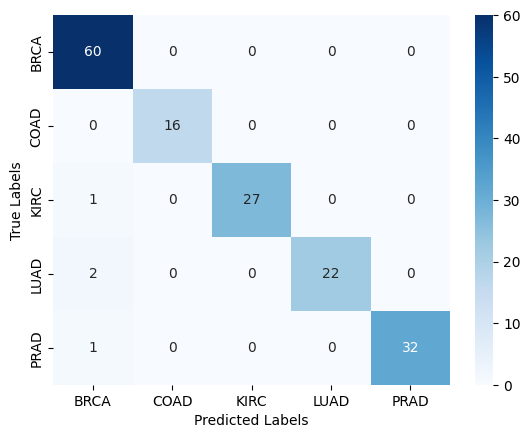

In [34]:
#visualize the confusion matrix using seaborn

sns.heatmap(cm_df,annot=True,cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

In [37]:
#visualize the confusion matrix directly
disp=plot_confusion_matrix(RF,X_test_selected,y_test,xticks_rotation='vertical',cmap='Blues',display_labels=labels)

NameError: name 'plot_confusion_matrix' is not defined

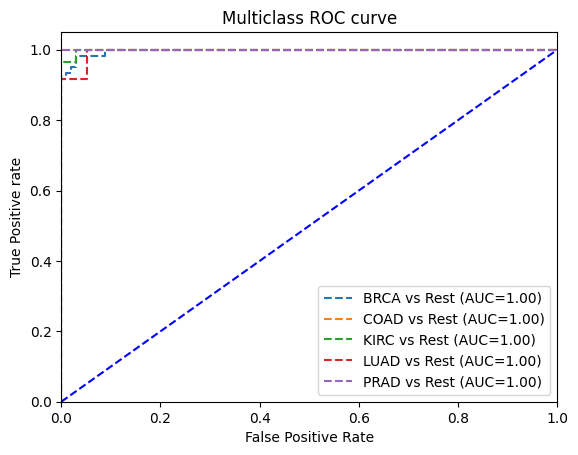

In [38]:
#roc curves will be generated for each class
#we will therefore have to binarize the y_test labels
#this is done because the probabilities(pred_prob) are calculated for each each class
#we therefore need to put the y_test label in the same format as the pred_prob
y_test_binarized=label_binarize(y_test,classes=classes)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}
roc_auc = dict()

n_class = classes.shape[0]

for i in range(n_class):
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test_binarized[:,i], pred_prob[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

    # plotting
    plt.plot(fpr[i], tpr[i], linestyle='--',
             label='%s vs Rest (AUC=%0.2f)'%(labels[i],roc_auc[i]))

plt.plot([0,1],[0,1],'b--')
plt.xlim([0,1])
plt.ylim([0,1.05])
plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='lower right')
plt.show()